# Imports

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    chi2,
    SelectPercentile,
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_Pipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance

In [2]:
data = pd.read_pickle("data_with_clusters.pkl")
data.head(5)

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,education_Master,education_PhD,MntRegularProds,AcceptedCmpOverall,MinorsAtHome,TotalMntSpent,marital_status,education,has_a_partner,cluster
0,58138.0,0,0,58,635,88,546,172,88,88,...,False,False,1441,0,0,3058,Single,Graduation,False,2
1,46344.0,1,1,38,11,1,6,2,1,6,...,False,False,15,0,2,42,Single,Graduation,False,1
2,71613.0,0,0,26,426,49,127,111,21,42,...,False,False,692,0,0,1468,Together,Graduation,True,2
3,26646.0,1,0,26,11,4,20,10,3,5,...,False,False,43,0,1,96,Together,Graduation,True,1
4,58293.0,1,0,94,173,43,118,46,27,15,...,False,True,392,0,1,814,Maried,PhD,True,3


<Axes: xlabel='count', ylabel='Response'>

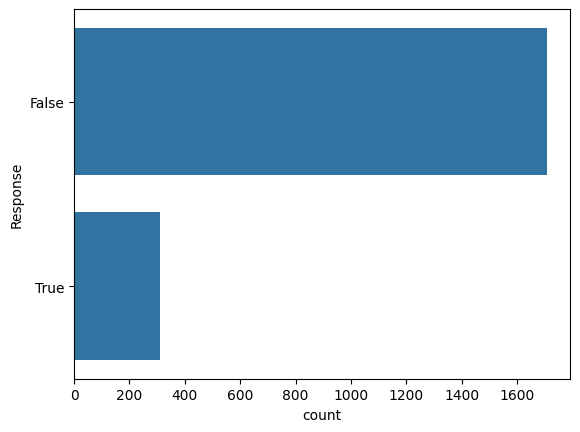

In [3]:
sns.countplot(y=data.Response)

# Preprocessing

LGBM and XGBOOST require categorical variables to be 'category' instead of 'object'

In [4]:
data.cluster = data.cluster.astype("object")
data[data.select_dtypes("object").columns] = data.select_dtypes("object").astype(
    "category"
)
data[data.drop("Response", axis=1).select_dtypes("bool").columns] = (
    data.drop("Response", axis=1).select_dtypes("bool").astype("category")
)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("Response", axis=1), data.Response, test_size=0.33, random_state=42
)


Removing columns made for EDA only

In [6]:
data.drop(
    [
        "marital_Divorced",
        "marital_Married",
        "marital_Single",
        "marital_Together",
        "marital_Widow",
        "education_2n Cycle",
        "education_Basic",
        "education_Graduation",
        "education_Master",
        "education_PhD",
    ],
    axis=1,
    inplace=True,
)


In [7]:
cont_cols = data.select_dtypes("number").columns
cont_cols


Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age',
       'Customer_Days', 'MntRegularProds', 'AcceptedCmpOverall',
       'MinorsAtHome', 'TotalMntSpent'],
      dtype='object')

In [8]:
continuous_variables_processing = imb_Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "ftr_sel",
            SelectFromModel(
                RandomForestClassifier(), threshold=-np.inf, max_features=10
            ),
        ),
    ]
)


In [9]:
cat_cols = data.select_dtypes("category").columns
cat_cols


Index(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'marital_status', 'education',
       'has_a_partner', 'cluster'],
      dtype='object')

In [10]:
discrete_variables_processing = imb_Pipeline(
    [("encoding", OneHotEncoder()), ("selector", SelectPercentile(chi2, percentile=25))]
)


In [11]:
preprocessor = ColumnTransformer(
    [
        ("num", continuous_variables_processing, cont_cols),
        ("cat", discrete_variables_processing, cat_cols),
    ]
)


# Dummy Classifier

In [12]:
dummy_clf = DummyClassifier().fit(X_train, y_train)
print(classification_report(y_test, dummy_clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.83      1.00      0.91       553
        True       0.00      0.00      0.00       113

    accuracy                           0.83       666
   macro avg       0.42      0.50      0.45       666
weighted avg       0.69      0.83      0.75       666



c:\Users\Rafael\Documents\Projects\projects-env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rafael\Documents\Projects\projects-env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rafael\Documents\Projects\projects-env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [13]:
models = {}

# Logistic Regression

In [14]:
lr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegressionCV()),
    ]
)
models['LogisticRegression'] = lr_pipe

## With SMOTE

In [15]:
lr_pipe_smote = imb_Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE()),
        ("model", LogisticRegressionCV()),
    ]
)
models['LogisticRegression_SMOTE'] = lr_pipe_smote

# RandomForest

In [16]:
rf_pipe = imb_Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ("model", RandomForestClassifier()),
    ]
)
models['RandomForestClassifier'] = rf_pipe

## With SMOTE

In [17]:
rf_pipe_smote = imb_Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ("smote", SMOTE()),
        ("model", RandomForestClassifier()),
    ]
)
models['RandomForestClassifier_SMOTE'] = rf_pipe_smote

# Neural Network

In [18]:
mlp_pipe = imb_Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", MLPClassifier(hidden_layer_sizes=(32,), max_iter=5000)),
    ]
)
models['MLPClassifier'] = mlp_pipe

## With SMOTE

In [19]:
mlp_pipe_smote = imb_Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE()),
        ("model", MLPClassifier(hidden_layer_sizes=(32,), max_iter=5000)),
    ]
)
models['MLPClassifier_SMOTE'] = mlp_pipe_smote

# XGBoost

In [20]:
xgb_pipe = imb_Pipeline(
    steps=[
        ("model", XGBClassifier(enable_categorical=True)),
    ]
)
models['XGBClassifier'] = xgb_pipe

## With SMOTE

In [21]:
xgb_pipe_smote = imb_Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ("smote", SMOTE()),
        ("model", XGBClassifier(enable_categorical=True)),
    ]
)
models['XGBClassifier_SMOTE'] = xgb_pipe_smote

# LGBM

In [22]:
lgbm_pipe = imb_Pipeline(
    steps=[
        ("model", LGBMClassifier()),
    ]
)
models['LGBMClassifier'] = lgbm_pipe

## With SMOTE

In [23]:
lgbm_pipe_smote = imb_Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ("smote", SMOTE()),
        ("model", LGBMClassifier(enable_categorical=True)),
    ]
)
models['LGBMClassifier_SMOTE'] = lgbm_pipe_smote

# Comparing models

In [35]:
results = {}
for key, model in models.items():
    print(f'Training {key}')
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_weighted')
    results[key] = np.mean(scores)

Training LogisticRegression
Training LogisticRegression_SMOTE
Training RandomForestClassifier
Training RandomForestClassifier_SMOTE
Training MLPClassifier
Training MLPClassifier_SMOTE
Training XGBClassifier
Training XGBClassifier_SMOTE
Training LGBMClassifier
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 178, number of negative: 1038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 1216, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146382 -> initscore=-1.763268
[LightGBM] [Info] Start training from score -1.763268
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 178, number of negative: 1038
[LightGBM] [Info] Auto

In [36]:
results_pd = pd.Series(results).sort_values(ascending=False)

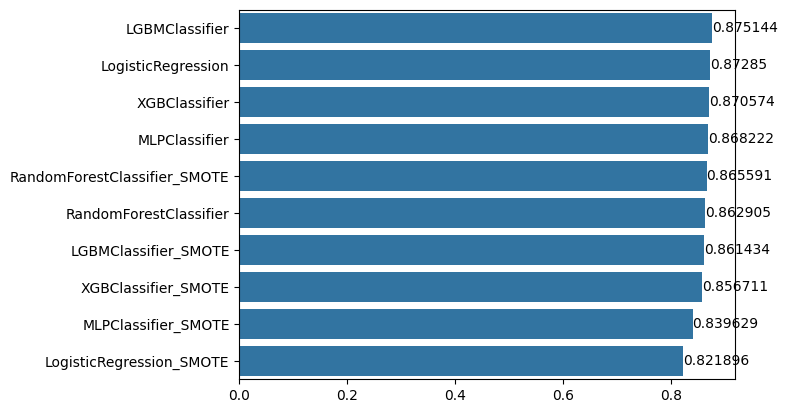

In [37]:
ax = sns.barplot(results_pd, orient='h')
_ = ax.bar_label(ax.containers[0])

LGBM and Logistic Regression got the best results for this dataset. SMOTE didn't help to get better results

# Optimization

In [41]:
def objective(trial):

    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'n_estimators ': trial.suggest_int('n_estimators', 100, 200),
    }
    
    lgbm = LGBMClassifier(**param)
    
    scores = cross_val_score(lgbm, X_train, y_train, cv=10, scoring='f1_weighted')

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-06-15 20:32:01,514] A new study created in memory with name: no-name-c9f2b76e-082c-409b-8ca5-82eb006be0c1
[I 2024-06-15 20:32:01,868] Trial 0 finished with value: 0.7861148546182528 and parameters: {'lambda_l1': 0.0019591874913307775, 'lambda_l2': 1.2897124882396511, 'num_leaves': 190, 'feature_fraction': 0.4555883942471205, 'bagging_fraction': 0.5508688630550167, 'bagging_freq': 5, 'min_child_samples': 21, 'n_estimators': 186}. Best is trial 0 with value: 0.7861148546182528.
[I 2024-06-15 20:32:02,336] Trial 1 finished with value: 0.7861148546182528 and parameters: {'lambda_l1': 3.3367953579353895e-05, 'lambda_l2': 7.83126974236551e-08, 'num_leaves': 242, 'feature_fraction': 0.9467196487291548, 'bagging_fraction': 0.42871814983050766, 'bagging_freq': 1, 'min_child_samples': 12, 'n_estimators': 131}. Best is trial 0 with value: 0.7861148546182528.
[I 2024-06-15 20:32:02,796] Trial 2 finished with value: 0.7861148546182528 and parameters: {'lambda_l1': 2.5710031692320968e-05, 'l

In [42]:
final_clf = LGBMClassifier(**study.best_params)
final_clf.fit(X_train, y_train)
print(classification_report(y_test, final_clf.predict(X_test)))

[LightGBM] [Warning] feature_fraction is set=0.8018765079162634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8018765079162634
[LightGBM] [Warning] lambda_l1 is set=0.13043899484996097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13043899484996097
[LightGBM] [Warning] lambda_l2 is set=0.014557861665952868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014557861665952868
[LightGBM] [Warning] bagging_fraction is set=0.6680007586477517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6680007586477517
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8018765079162634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8018765079162634
[LightGBM] [Warning] lambda_l1 is set=0.13043899484996097, reg_alpha=0.0 will be ign

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

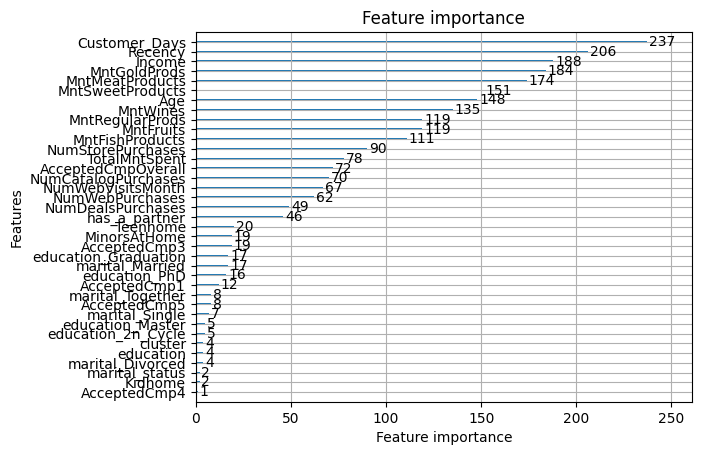

In [44]:
plot_importance(final_clf)

# Saving model

In [45]:
final_clf.booster_.save_model('lgbm_clf.txt')